# Magnification factor on Thermal-Variational Auto-Encoder toy example
[Yusuke Hayashi](https://github.com/hayashiyus)<br/>
November 20, 2019 <br/>

## Variational inference
Given samples $x$ from an unobserved data density $q(x)$, we are interested in building a latent-variable generative model $p(x, z)$ such that $p(x)$ is close to $q(x)$. This is a difficult problem as evaluating the density under the model, $p(x)$ requires evaluating an intractable integral over the unobserved latent variable $z$: $p(x)=\int \text{d}z \;p(x, z)$.

Variational inference bypasses this problem by optimizing a lower bound on the log-likelihood of the data:
$$\log p(x) \ge -\text{KL}\left(q(z|x) \| p(z)\right) + \mathbb{E}_{q(z|x)}\left[\log p(x|z)\right]$$
This lower bound depends on an additional distribution, $q(z|x)$ which is known as the _variational distribution_ and acts as an approximation to the true posterior $p(z|x)$. 
To evaluate and learn using the variational lower bound, we need to be able to draw samples from the _variational distribution_ and to evaluate the density of a sample from the _variational distribution_. This typically restricts the family of variational distributions to those with known or tractable densities (e.g. factorial Gaussian, normalizing flows).

Send questions/comments/bugs to [@hayashiyus](https://twitter.com/hayashiyus).

## Setup

In [1]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.contrib.slim as slim
from tensorflow_probability import edward2 as ed
import matplotlib
import matplotlib.cm as cm
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-colorblind')
#rcParams['figure.figsize'] = 16, 4
%matplotlib inline
%load_ext autotime

# function shorthand 
tfc = tf.contrib
tfd = tfp.distributions
graph_replace = tfc.graph_editor.graph_replace

W0823 01:45:58.156358 4406371776 __init__.py:316] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W0823 01:45:58.237882 4406371776 __init__.py:316] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W0823 01:45:59.705163 4406371776 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Parameters

In [2]:
batch_size = 898
latent_dim = 2 # dimension of latent space
input_dim = 64 # dimension of input data
output_dim = 10 # dimension of output space
n_layer = 4  # number of hidden layers 
n_unit = 256  # number of hidden units 


time: 743 µs


## Create dataset of one-hot vectors

In [3]:
# load training datasets
from sklearn import datasets
import sklearn.preprocessing as sp
import sklearn.model_selection as sm

MNIST = datasets.load_digits()
X = MNIST.data # X: images
X = X / 16 # normalize pixel values
yl = MNIST.target # yl: labels
D, n = X.shape

n_im_row, n_im_col = 5, 15
n_im = n_im_row * n_im_col
d = np.arange(D)
d_choice = np.random.choice(np.arange(D),n_im,replace=False)

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

'''
fig = plt.figure(figsize=(n_im_col,n_im_row))
gs = gridspec.GridSpec(n_im_row,n_im_col)
k = 0
for i in np.arange(n_im_row):
    for j in np.arange(n_im_col):
        ax = plt.subplot(gs[i,j])
        ax.imshow(X[d_choice[k],:].reshape(n_px_row,n_px_col),cmap='gray')
        ax.set_title(str(yl[d_choice[k]]))
        ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
        ax.tick_params(bottom=False,left=False,right=False,top=False)
        k = k + 1

plt.tight_layout()
plt.show()
'''

# split the dataset to train and test datasets 
X_train, X_test, yl_train, yl_test = sm.train_test_split(X, yl, train_size=1/2, test_size=1/2)

X_test = X_test[:-1]
yl_test = yl_test[:-1]

# create dataset of one-hot vectors
# class size
C = 10                      
# .A means 'change the data type from a matrix to an array'
enc = sp.OneHotEncoder()
Y_train = enc.fit_transform(yl_train.reshape(-1, 1)).A
Y_test = enc.fit_transform(yl_test.reshape(-1, 1)).A

print('訓練データ数：D_train =', len(Y_train))
print('テストデータ数：D_test =', len(Y_test))


データ数（画像の枚数）：D = 1797
特徴量数（ピクセル数）：n = 64
訓練データ数：D_train = 898
テストデータ数：D_test = 898
time: 108 ms


/Users/hayashiyus/env/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/hayashiyus/env/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


## Train model

In [4]:
def create_tf_graph(x, z):
    """
    creates the metric tensor (J^T J and J being the jacobian of the decoder), 
    which can be evaluated at any point in Z
    and
    the magnification factor
    """
    # the metric tensor
    output_dim = x.shape[1].value
    # derivative of each output dim wrt to input (tf.gradients would sum over the output)
    J = [tf.gradients(x[:, _], z)[0] for _ in range(output_dim)]
    J = tf.stack(J, axis=1)  # batch x output x latent
    G = tf.transpose(J, [0, 2, 1]) @ J  # J^T \cdot J
    # magnification factor
    mf = tf.sqrt(tf.linalg.det(G))
    return mf

def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)


time: 5.19 ms


W0823 01:46:00.182810 4406371776 deprecation.py:323] From /Users/hayashiyus/env/lib/python3.7/site-packages/tensorflow_core/contrib/layers/python/layers/layers.py:1866: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0823 01:46:00.847472 4406371776 deprecation.py:323] From /Users/hayashiyus/env/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1206: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
  0%|          | 4/4001 [00:00<28:07,  2.37it/s]

    0:(beta)=(    1.0000)


 25%|██▌       | 1004/4001 [00:48<02:46, 18.05it/s]

 1000:(beta)=(    0.9584)


 44%|████▎     | 1747/4001 [01:20<01:30, 24.92it/s]/Users/hayashiyus/env/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
 50%|█████     | 2005/4001 [01:31<01:21, 24.59it/s]

 2000:(beta)=(    0.9177)


 75%|███████▌  | 3004/4001 [02:13<00:48, 20.57it/s]

 3000:(beta)=(    0.8785)


100%|██████████| 4001/4001 [02:58<00:00, 22.44it/s]


 4000:(beta)=(    0.8417)


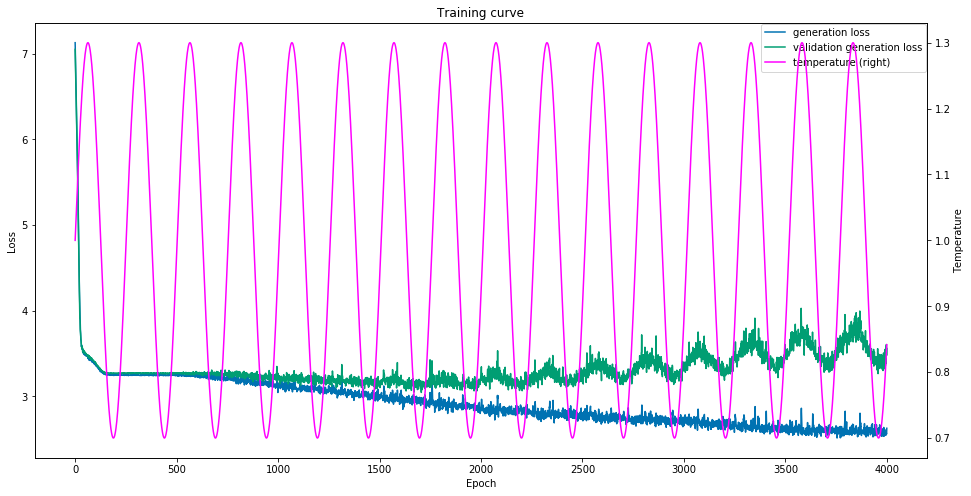

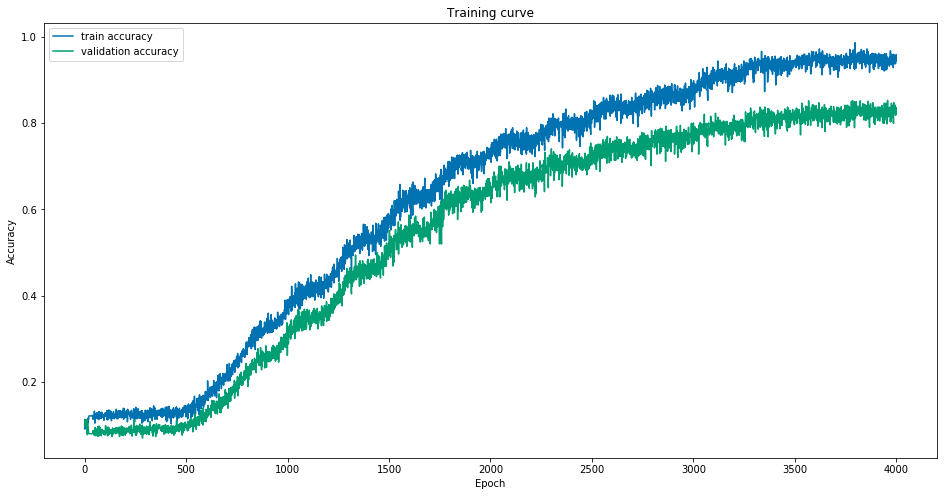

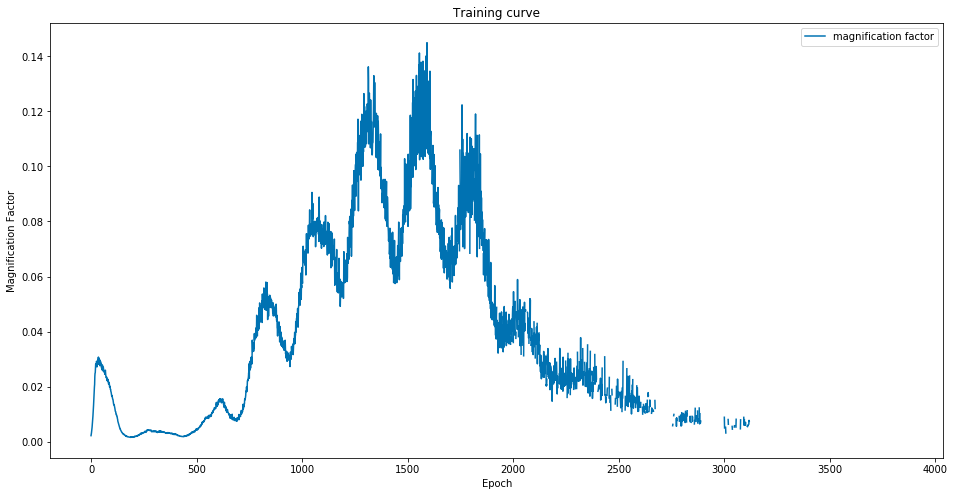

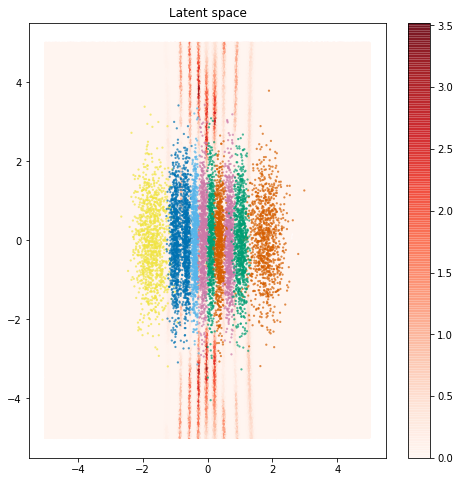

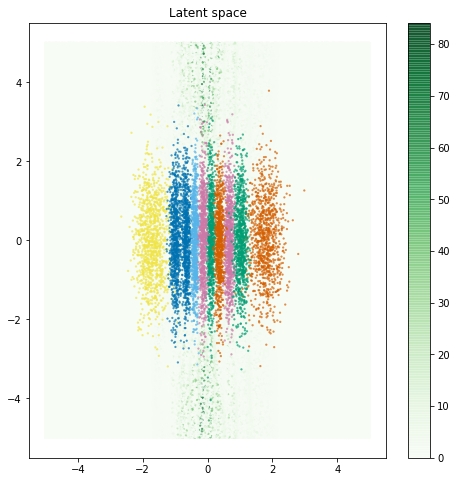

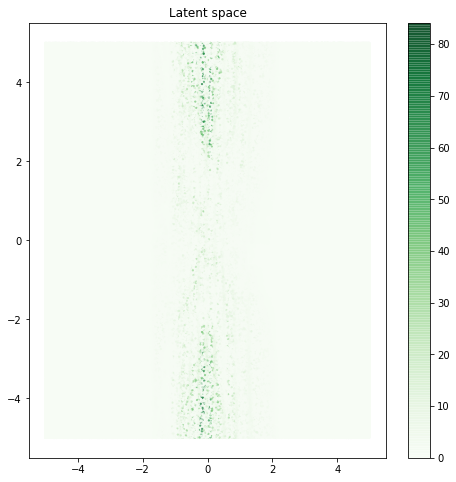

time: 4min 22s


In [5]:
n_epoch = 4000 + 1
beta = tf.constant(1.0)

x = tf.constant(X_train, dtype=tf.float32)
y = tf.constant(Y_train, dtype=tf.float32)

#Encoder
with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
    enc = tfc.layers.repeat(x, n_layer, tfc.layers.fully_connected, n_unit)
    loc = tfc.layers.fully_connected(enc, latent_dim, activation_fn = None)
    scale = tfc.layers.fully_connected(enc, latent_dim, activation_fn = tf.nn.softplus)
    
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim),
                                   scale_diag=tf.ones(latent_dim))
posterior = tfd.MultivariateNormalDiag(loc=loc,
                                       scale_diag=scale)
prior_sample = prior.sample(batch_size)
z_sample = tf.add(loc, tf.multiply(scale, prior_sample))
    
#Decoder
with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):    
    dec = tfc.layers.repeat(z_sample, n_layer, tfc.layers.fully_connected, n_unit)
    # clipping is necessary to prevent NaN when dec is too large 
    dec = 1e-6 + (1 - 2e-6) * tfc.layers.fully_connected(dec, output_dim,
                                                         activation_fn = tf.nn.sigmoid)
    # calculate log_probability in Bernoulli distribution
    log_probs = tfd.Bernoulli(probs=tf.pow(dec,beta)).log_prob(y)
    
#Magnification factor
mf = create_tf_graph(dec, z_sample)
#Fisher Infomation Factor
fif = create_tf_graph(log_probs, z_sample)
    
#Loss functions
# regularization_loss
kl_divergence = tfd.kl_divergence(posterior, prior)
# decoder loss
recon_likelihood = tf.reduce_sum(log_probs, axis=1)
# mmd loss
#loss_mmd = compute_mmd(prior_sample, z_sample)
# generator loss
#gen_loss = beta * tf.reduce_mean(kl_divergence) - tf.reduce_mean(recon_likelihood)
gen_loss = tf.reduce_mean(kl_divergence) - tf.reduce_mean(recon_likelihood)
#gen_loss = beta * loss_mmd - tf.reduce_mean(recon_likelihood)
#gen_loss = beta * tf.reduce_mean(mf) - tf.reduce_mean(recon_likelihood)

correct = tf.equal(tf.argmax(y, 1), tf.argmax(dec, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "decoder")

opt = tf.train.AdamOptimizer(2e-4, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list = qvars + pvars)
    
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
    
with tf.Session() as sess:

    sess.run(init_g)
    sess.run(init_l)

    ac_list = []
    gen_loss_list = []
    val_list = []
    val_gen_loss_list = []
    beta_list = []
    fifs_list = []
    
    beta_min = 0.3
    cyclical_beta = 1.0 + beta_min * np.sin(100/n_epoch * np.arange(n_epoch))
    #cyclical_beta = np.repeat(beta_min, n_epoch)
    
    for j in tqdm(range(n_epoch)):
        ac, gl, _ = sess.run([accuracy, gen_loss, train_gen_op], feed_dict={beta: cyclical_beta[j]})
        val_ac, val_gl = sess.run([accuracy, gen_loss], feed_dict={beta: cyclical_beta[j], x: X_test, y: Y_test})
        fifs = sess.run(fif)
        ac_list.append(ac)        
        gen_loss_list.append(gl)
        val_list.append(val_ac)
        val_gen_loss_list.append(val_gl)   
        beta_list.append(cyclical_beta[j])
        fifs_list.append(np.median(fifs))
        if j % 1000 == 0:
            print("%5d:(beta)=(%10.4f)" % (j, cyclical_beta[j]))
            
    rcParams['figure.figsize'] = 16, 8
    fig, ax1 = plt.subplots() 
    ax2 = ax1.twinx()
    ax1.plot(np.arange(n_epoch), np.asarray(gen_loss_list), label='generation loss')
    ax1.plot(np.arange(n_epoch), np.asarray(val_gen_loss_list), label='validation generation loss')
    ax2.plot(np.arange(n_epoch), np.asarray(beta_list), label='temperature (right)', color='magenta')
    handler1, label1 = ax1.get_legend_handles_labels()
    handler2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(handler1 + handler2, label1 + label2, loc=1, borderaxespad=0.1)
    plt.title('Training curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Temperature')
    plt.show()

    rcParams['figure.figsize'] = 16, 8
    plt.figure()
    plt.plot(np.arange(n_epoch), np.asarray(ac_list))
    plt.plot(np.arange(n_epoch), np.asarray(val_list))
    plt.legend(['train accuracy', 'validation accuracy'])
    plt.title('Training curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    rcParams['figure.figsize'] = 16, 8
    plt.figure()
    plt.plot(np.arange(n_epoch), np.asarray(fifs_list))
    plt.legend(['magnification factor'])
    plt.title('Training curve')
    plt.xlabel('Epoch')
    plt.ylabel('Magnification Factor')
    plt.show()

    n_vis = 10
    enc_test = np.vstack([sess.run(z_sample) for _ in range(n_vis)])
    enc_test_label = np.tile(yl_train, (n_vis))
    n_vis = 1000
    z_range = np.random.uniform(-5, 5, size=(batch_size*n_vis, latent_dim))
    mfs = np.hstack([sess.run(mf, feed_dict={z_sample: z_range[_*batch_size:(_+1)*batch_size]}) for _ in range(n_vis)])
    fifs = np.hstack([sess.run(fif, feed_dict={z_sample: z_range[_*batch_size:(_+1)*batch_size]}) for _ in range(n_vis)])

    rcParams['figure.figsize'] = 8, 8
    plt.figure()
    plt.scatter(z_range[:, 0], z_range[:, 1],
                c=mfs, cmap=plt.cm.Reds,
                edgecolor='none', alpha=0.7, s=5)
    plt.colorbar()
    for i in range(len(np.unique(yl_train))):
        plt.scatter(enc_test[enc_test_label==i, 0], enc_test[enc_test_label==i, 1], 
                    edgecolor='none', alpha=0.7, s=5)
    plt.title('Latent space')
    plt.show()

    rcParams['figure.figsize'] = 8, 8
    plt.figure()
    plt.scatter(z_range[:, 0], z_range[:, 1],
                c=fifs, cmap=plt.cm.Greens,
                edgecolor='none', alpha=0.7, s=5)
    plt.colorbar()
    for i in range(len(np.unique(yl_train))):
        plt.scatter(enc_test[enc_test_label==i, 0], enc_test[enc_test_label==i, 1], 
                    edgecolor='none', alpha=0.7, s=5)
    plt.title('Latent space')
    plt.show()
    
    rcParams['figure.figsize'] = 8, 8
    plt.figure()
    plt.scatter(z_range[:, 0], z_range[:, 1],
                c=fifs, cmap=plt.cm.Greens,
                edgecolor='none', alpha=0.7, s=5)
    plt.colorbar()
    plt.title('Latent space')
    plt.show()
